In [94]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import pylab as pl
import geopandas as gpd
import folium
from folium import plugins

In [95]:
# set up datasets
root = os.getcwd()
cities = pd.read_csv(root + "/cities.csv")
stations = pd.read_csv(root + "/stations.csv")
tracks = pd.read_csv(root + "/tracks.csv")
lines = pd.read_csv(root + "/lines.csv")
track_lines = pd.read_csv(root + "/track_lines.csv")

In [96]:
id_list = []
name_list = []
for i in cities.index:
    if cities.country[i] in ["Scotland", "England"]:    
        id_list.append(cities.id[i])
        name_list.append(cities.name[i])
print(id_list)
print(name_list)

[5, 20, 26, 45, 48, 65, 68, 72, 97, 89, 69]
['Aberdeen', 'Birmingham', 'Bristol', 'Edinburgh', 'Glasgow', 'Leeds', 'Liverpool', 'Manchester', 'Plymouth', 'Newcastle-on-Tyne', 'London']


In [97]:
city_dict = {}
for i in range(0, len(id_list)):
    line = lines[lines.city_id == id_list[i]]
    track_line = track_lines[track_lines.city_id == id_list[i]]
    track = tracks[tracks.city_id == id_list[i]].drop(['buildstart', 'opening', 'closure', 'city_id'], axis = 1)
    track.columns = ['section_id','geometry','length']
    track_line = pd.merge(track_line, track)
    track_line = track_line.drop(['id', 'created_at', 'updated_at', 'city_id'], axis = 1)
    track_line.columns = ['section_id', 'id', 'geometry', 'length']
    line = pd.merge(track_line, line)
    city_dict[name_list[i]] = line

In [98]:
data_cities = {}
for key, value in city_dict.items():
    if key not in data_cities:
        data_cities[key] = {}
    for i in range(len(value)):
        coord = value.iloc[i].geometry.split('(')[1].split(')')[0].split(',')
        for j in range(len(coord)):
            longitude = coord[j].split(' ')[0]
            latitude = coord[j].split(' ')[1]
            if value.url_name[i] in data_cities[key]:
                data_cities[key][value.url_name[i]].append([longitude, latitude])
            else:
                data_cities[key][value.url_name[i]] = [[longitude, latitude]]

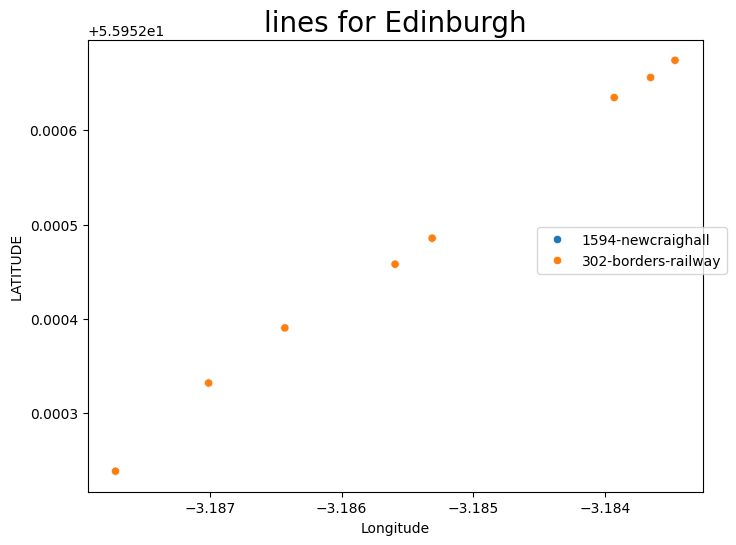

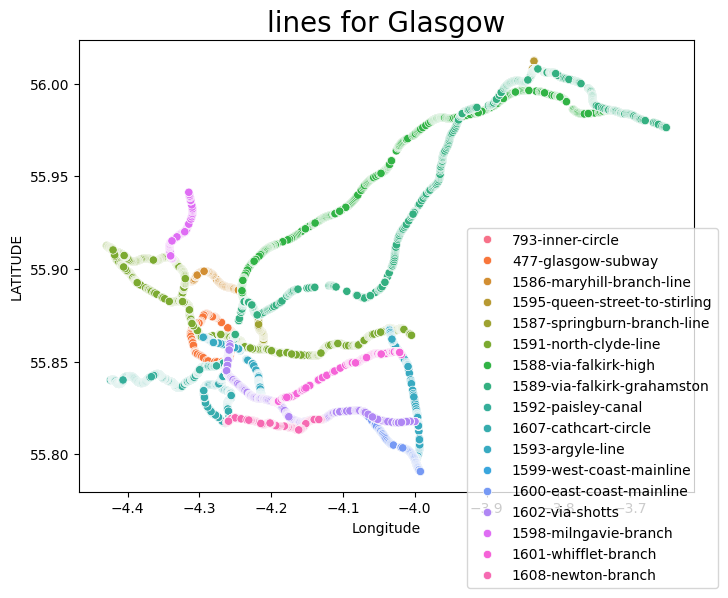

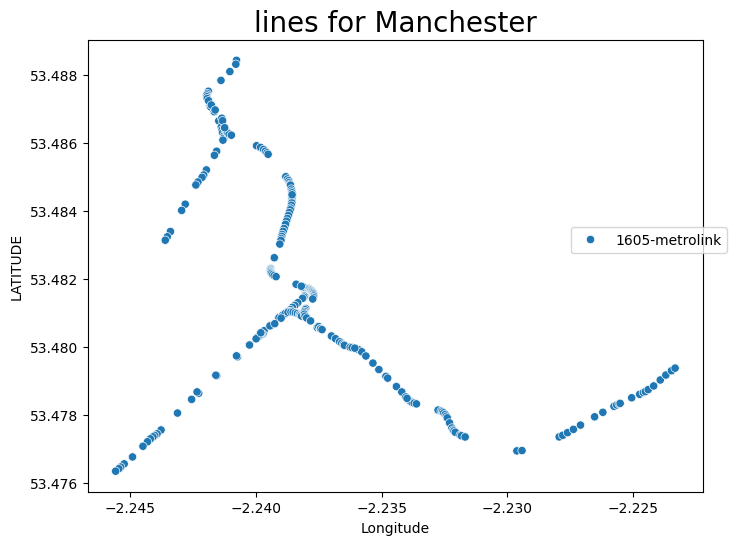

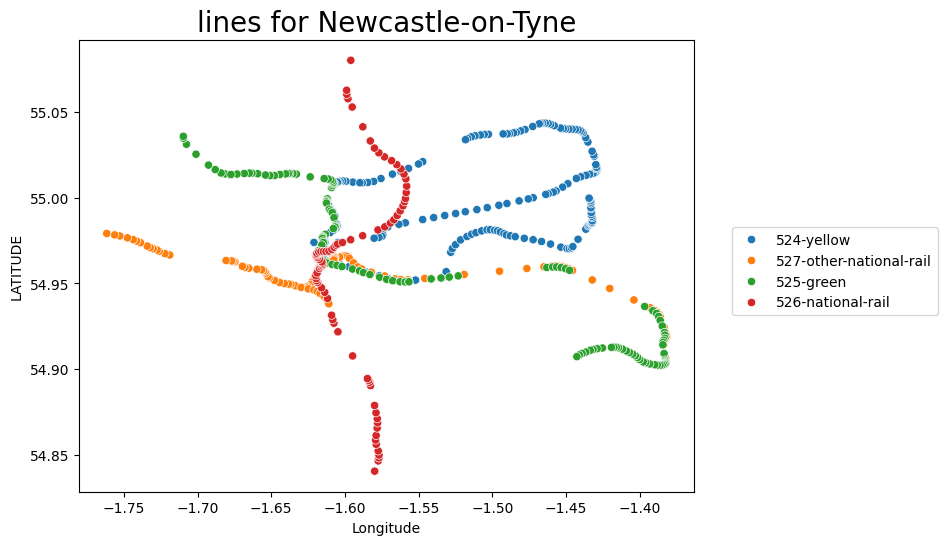

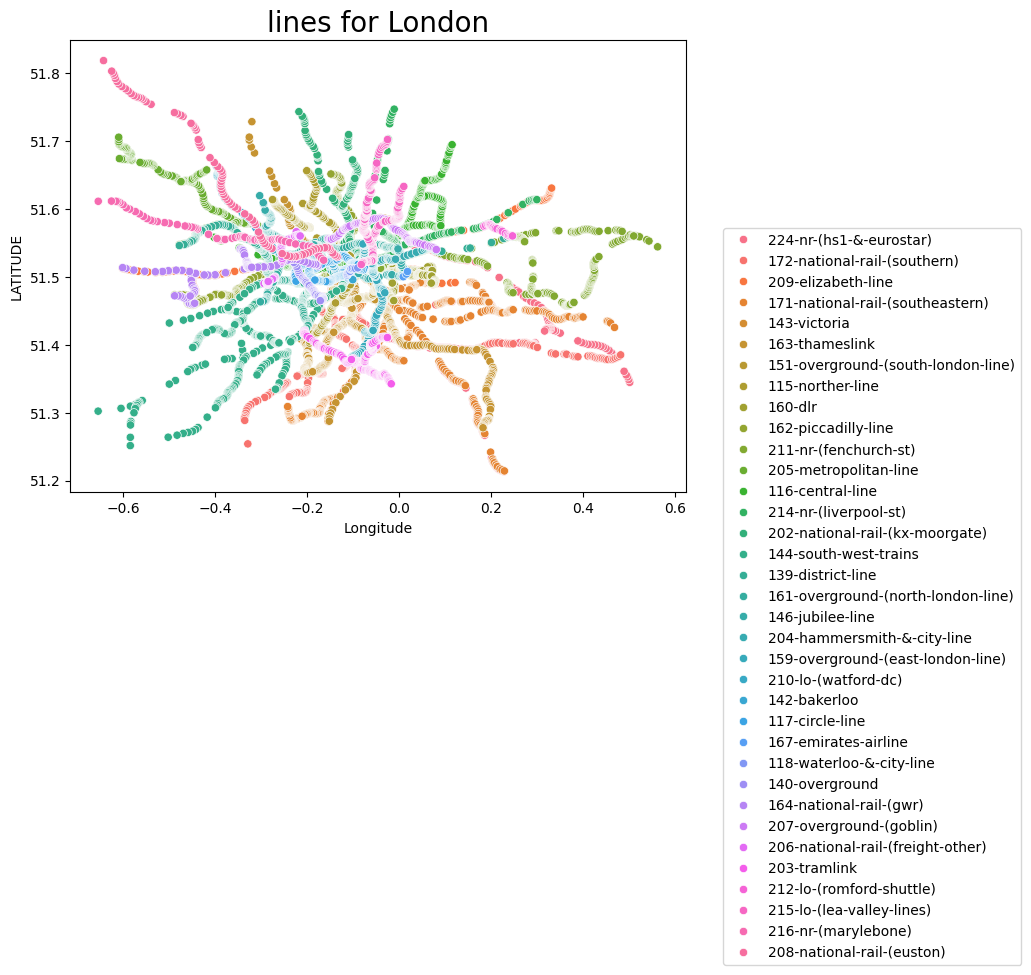

In [99]:
# visulization of cities before transforming to network
for key, values in data_cities.items():
    if values == {}:
        continue
    longitude = []
    latitude = []
    line = []
    for k, v in values.items():
        for i in range(len(v)):
            longitude.append(v[i][0])
            latitude.append(v[i][1])
            line.append(k)
            fix = pd.DataFrame({'x': longitude,'y': latitude,'z': line})
    fix['x'] = fix['x'].astype(float)
    fix['y'] = fix['y'].astype(float)
    plt.figure(figsize = (27, 27))
    plt.subplot(4, 3, 1) 
    ax = sns.scatterplot(x = "x", y = "y", hue = "z", data = fix)
    plt.legend(loc = 0, bbox_to_anchor=(1.05, 0.6))
    plt.title(f"lines for {key}", size = 20)
    ax.set(xlabel = 'Longitude', ylabel = 'LATITUDE')

In [100]:
import networkx as nx
from math import dist
Graphs = {}
data = {}

def euclidean_distance(station1, station2):
    return dist((float(station1[0]), float(station1[1])), (float(station2[0]), float(station2[1])))

useful_list = ["Edinburgh", "Glasgow", "Manchester", "Newcastle-on-Tyne", "London"]

for city in useful_list:
    G1 = nx.Graph()
    working_dict = data_cities[city]

    for line, coordinates in working_dict.items():
        for i in range(len(coordinates) - 1):
            node1 = tuple(map(float, coordinates[i]))
            node2 = tuple(map(float, coordinates[i + 1]))
            G1.add_node(node1)
            G1.add_node(node2)
            G1.add_edge(node1, node2)

    lines = list(working_dict.keys())
    for i in range(len(lines) - 1):
        line1 = lines[i]
        line2 = lines[i + 1]

        closest_distance = float('inf')
        closest_stations = None

        for station1 in working_dict[line1]:
            for station2 in working_dict[line2]:
                distance = euclidean_distance(station1, station2)
                if distance < closest_distance:
                    closest_distance = distance
                    closest_stations = (tuple(map(float, station1)), tuple(map(float, station2)))

        G1.add_edge(closest_stations[0], closest_stations[1])
    Graphs[city] = G1

print(Graphs)


{'Edinburgh': <networkx.classes.graph.Graph object at 0x2c347a660>, 'Glasgow': <networkx.classes.graph.Graph object at 0x2c51b5eb0>, 'Manchester': <networkx.classes.graph.Graph object at 0x2b90cccb0>, 'Newcastle-on-Tyne': <networkx.classes.graph.Graph object at 0x2b9216540>, 'London': <networkx.classes.graph.Graph object at 0x2c37e9f40>}


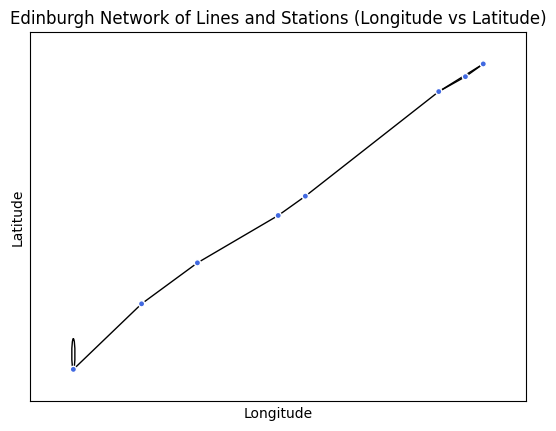

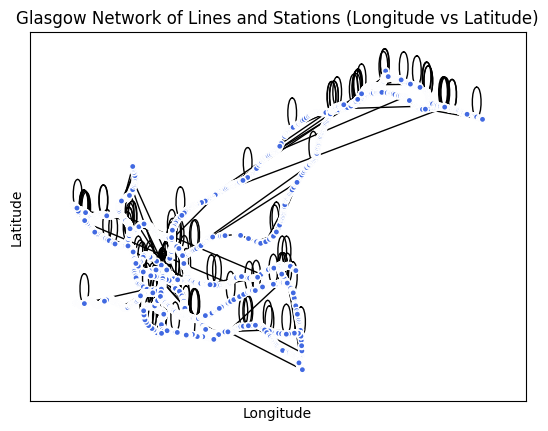

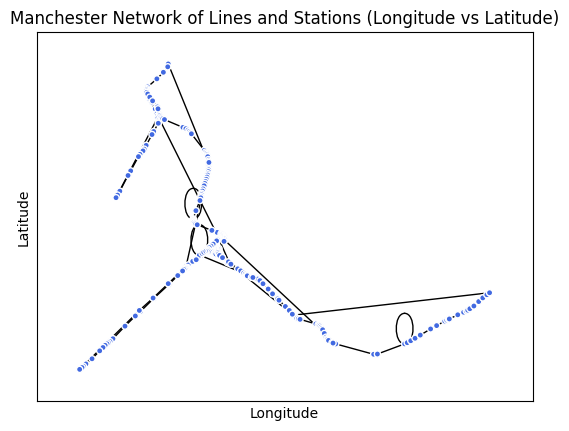

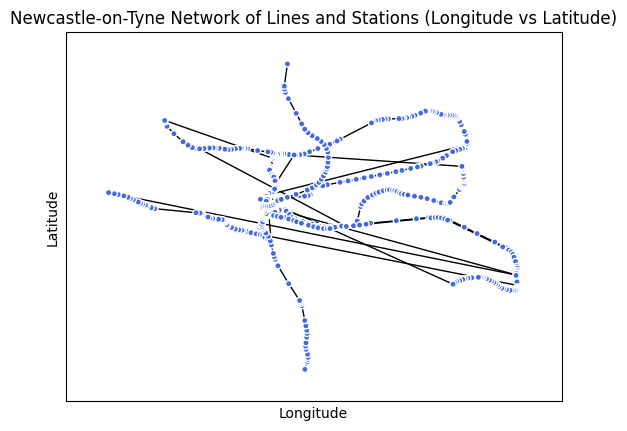

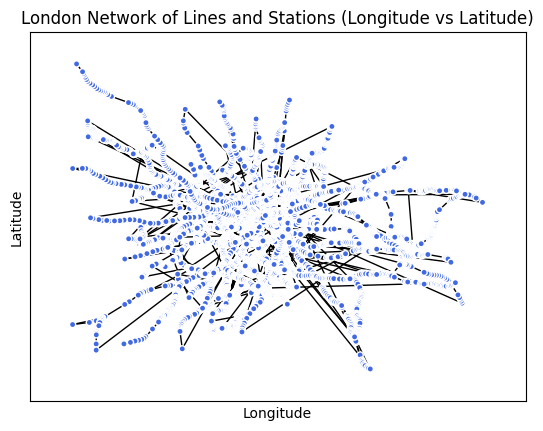

In [101]:
for name, G in Graphs.items():
    pos = {node: (float(node[0]), float(node[1])) for node in G.nodes()}  # Positions based on longitude and latitude

    edge_colors = [G.edges[edge]['line'] if 'line' in G.edges[edge] else 'black' for edge in G.edges]

    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color=edge_colors)

    node_colors = [G.nodes[node]['line'] if 'line' in G.nodes[node] else 'royalblue' for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color=node_colors, linewidths=1, edgecolors='white')  # Set linewidths and edgecolors

    # labels = {node: f"{node}" for node in G.nodes()}
    # nx.draw_networkx_labels(G, pos, labels=labels, font_size=6, font_color='black', font_weight='bold')

    plt.title(f'{name} Network of Lines and Stations (Longitude vs Latitude)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

In [102]:
data = {}

In [103]:
for name, G in Graphs.items():
    if name not in data:
        data[name] = {}
    data[name]["density"] = nx.density(G)

In [104]:
for name, G in Graphs.items():
    data[name]["num_edge"] = len(G.edges())
    data[name]["num_node"] = len(G.nodes())
    data[name]["average_degree"] = sum(dict(G.degree()).values()) / len(G)

In [105]:
for k, v in data.items():
    print(k, v)

Edinburgh {'density': 0.32142857142857145, 'num_edge': 9, 'num_node': 8, 'average_degree': 2.25}
Glasgow {'density': 0.0005947953324818398, 'num_edge': 4282, 'num_node': 3795, 'average_degree': 2.2566534914361003}
Manchester {'density': 0.008821478382147838, 'num_edge': 253, 'num_node': 240, 'average_degree': 2.1083333333333334}
Newcastle-on-Tyne {'density': 0.0037174721189591076, 'num_edge': 537, 'num_node': 538, 'average_degree': 1.996282527881041}
London {'density': 0.00027616680475006904, 'num_edge': 7241, 'num_node': 7242, 'average_degree': 1.9997238331952498}


In [106]:
# analysis for France
id_list = []
name_list = []
for i in cities.index:
    if cities.country[i] == "France":    
        id_list.append(cities.id[i])
        name_list.append(cities.name[i])
print(id_list)
print(name_list)

[273, 274, 269, 270, 271, 272, 276, 277, 278, 279, 280, 23, 281, 282, 284, 285, 287, 288, 289, 290, 291, 283, 292, 295, 296, 297, 298, 299, 294, 301, 302, 303, 304, 300, 70, 309, 74, 306, 311, 312, 313, 315, 316, 319, 320, 321, 322, 323, 310, 305, 317, 324, 314, 318, 308, 331, 327, 95, 325, 326, 329, 330, 332, 333, 328, 307, 275, 286, 293, 265, 266]
['St.-Brieuc', 'Poitier', 'Annecy', 'Roanne', 'Roura', 'Sinnamary', 'Biarritz', 'Aix-en-Provence', 'Perpignan', 'Tarbes', 'Clermont-Ferrand', 'Bordeaux', 'Melun', 'Arras', 'Saint-Georges', 'Saint-Etienne', 'Fort-de-France', 'Saint-Laurent-du-Maroni', 'Iracoubo', 'Cherbourg', 'Caen', 'Besancon', 'Lorient', 'Agen', 'Ajaccio', 'Bastia', 'Toulon', 'Beziers', 'Le Mans', 'Nimes', 'Vichy', 'Nevers', 'Auxerre', 'Montpellier', 'Lyons', 'Dieppe', 'Marseilles', 'Bourges', 'Versailles', 'Brive', 'Troyes', 'Calais', 'Amiens', 'Metz', 'Pointe-a-Pitre', 'Basse-terre', 'St.-Benoit', 'Dzaoudzi', 'Rouen', 'Dijon', 'Mulhouse', 'Nice', 'Reims', 'Nancy', 'Orlea

In [107]:
root = os.getcwd()
cities = pd.read_csv(root + "/cities.csv")
stations = pd.read_csv(root + "/stations.csv")
tracks = pd.read_csv(root + "/tracks.csv")
lines = pd.read_csv(root + "/lines.csv")
track_lines = pd.read_csv(root + "/track_lines.csv")

In [108]:
city_dict = {}
for i in range(0, len(id_list)):
    line = lines[lines.city_id == id_list[i]]
    track_line = track_lines[track_lines.city_id == id_list[i]]
    track = tracks[tracks.city_id == id_list[i]].drop(['buildstart', 'opening', 'closure', 'city_id'], axis = 1)
    track.columns = ['section_id','geometry','length']
    track_line = pd.merge(track_line, track)
    track_line = track_line.drop(['id', 'created_at', 'updated_at', 'city_id'], axis = 1)
    track_line.columns = ['section_id', 'id', 'geometry', 'length']
    line = pd.merge(track_line, line)
    city_dict[name_list[i]] = line

In [109]:
data_cities = {}
for key, value in city_dict.items():
    if key not in data_cities:
        data_cities[key] = {}
    for i in range(len(value)):
        coord = value.iloc[i].geometry.split('(')[1].split(')')[0].split(',')
        for j in range(len(coord)):
            longitude = coord[j].split(' ')[0]
            latitude = coord[j].split(' ')[1]
            if value.url_name[i] in data_cities[key]:
                data_cities[key][value.url_name[i]].append([longitude, latitude])
            else:
                data_cities[key][value.url_name[i]] = [[longitude, latitude]]

/var/folders/kp/42mf2zln4td3739_7tq6yr1w0000gn/T/ipykernel_39065/1978285900.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (27, 27))


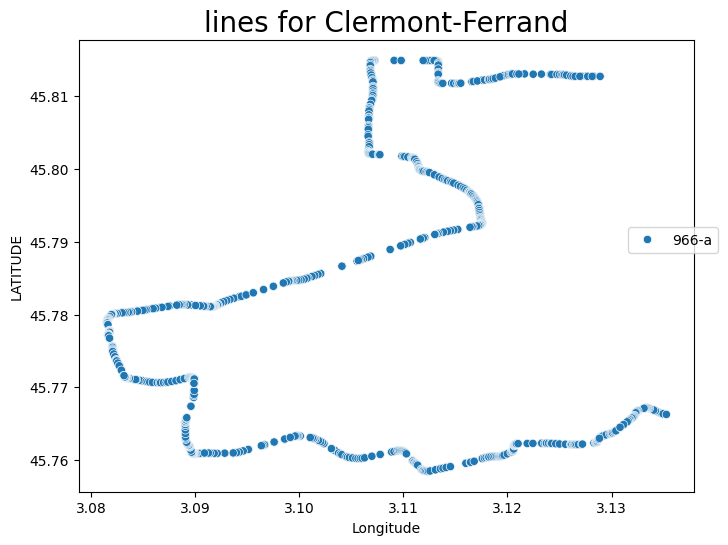

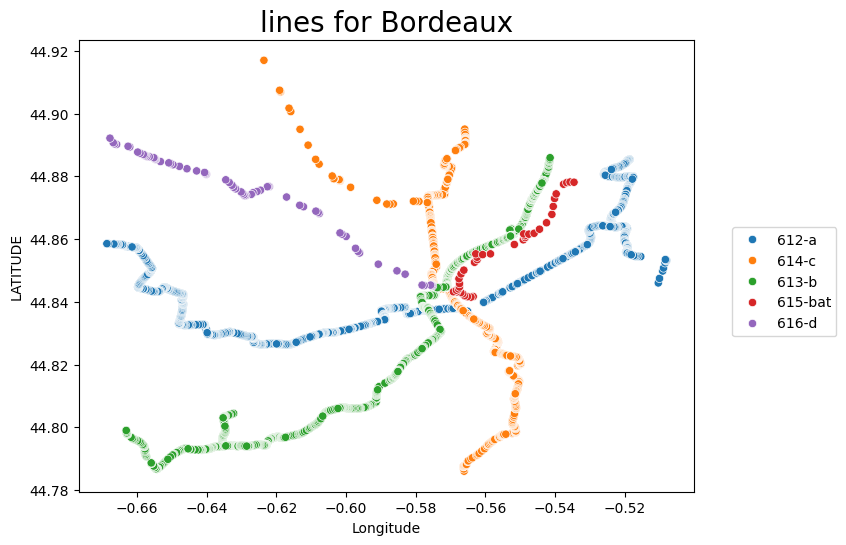

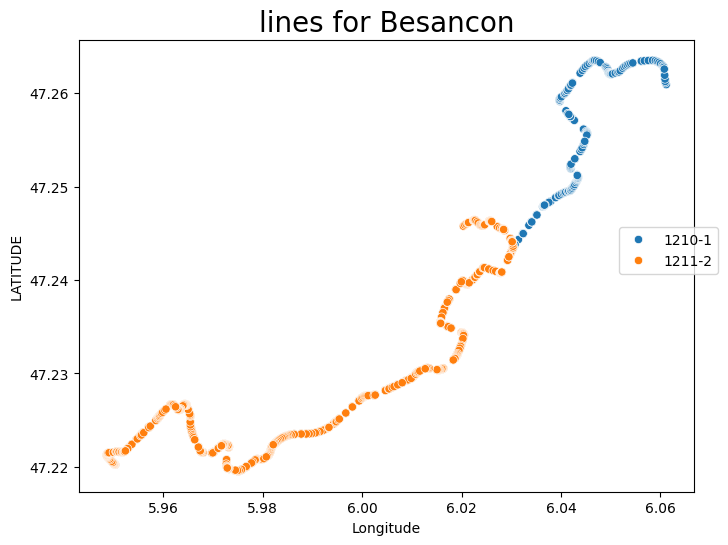

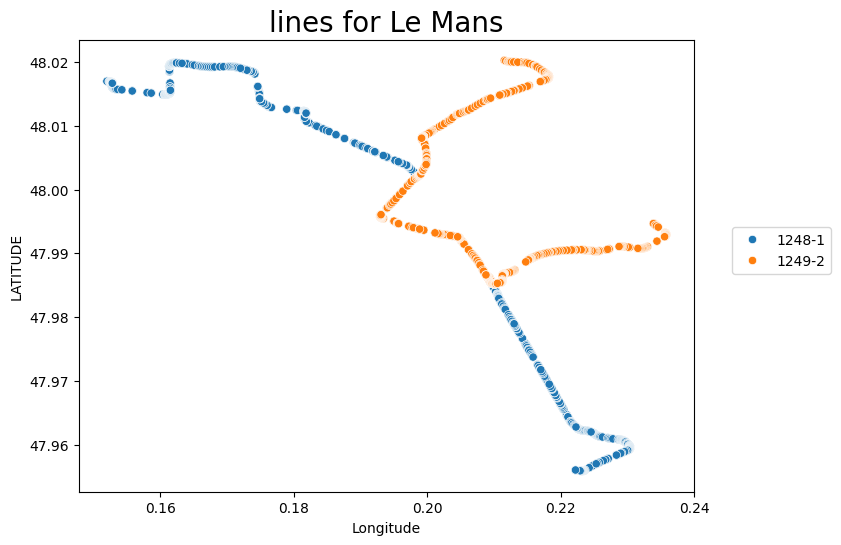

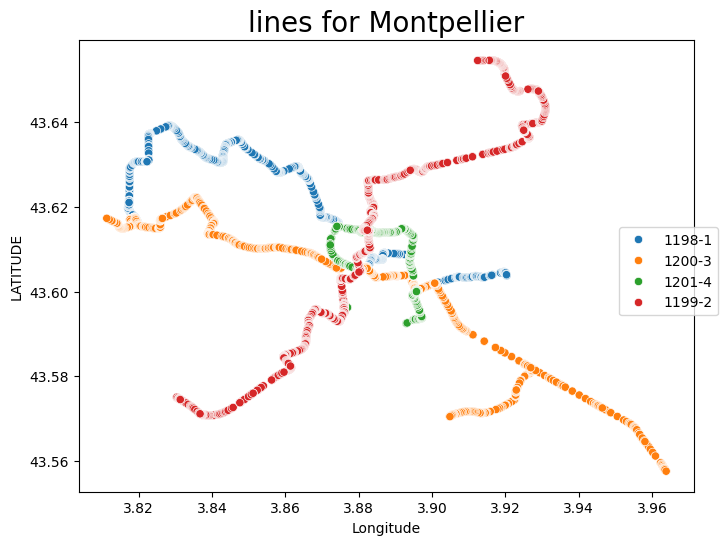

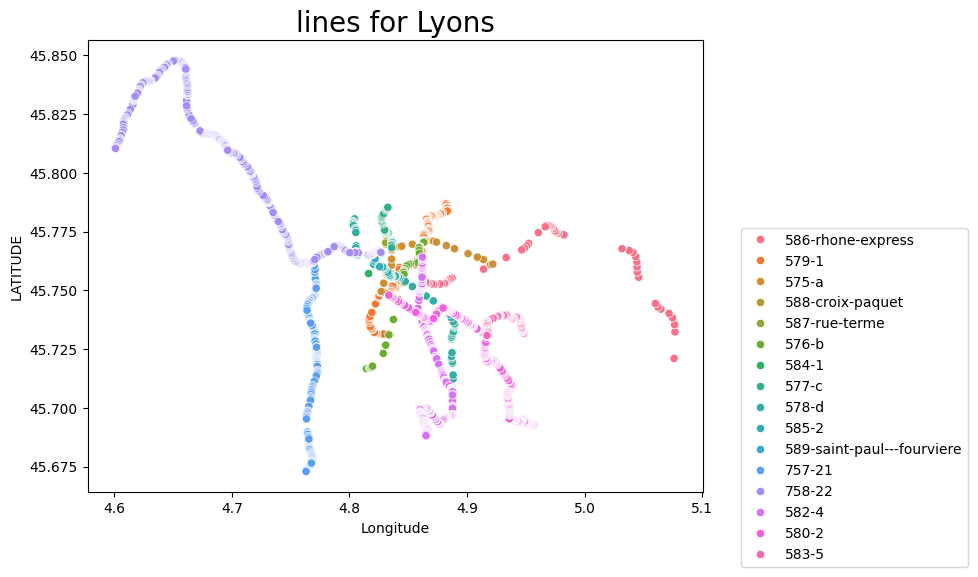

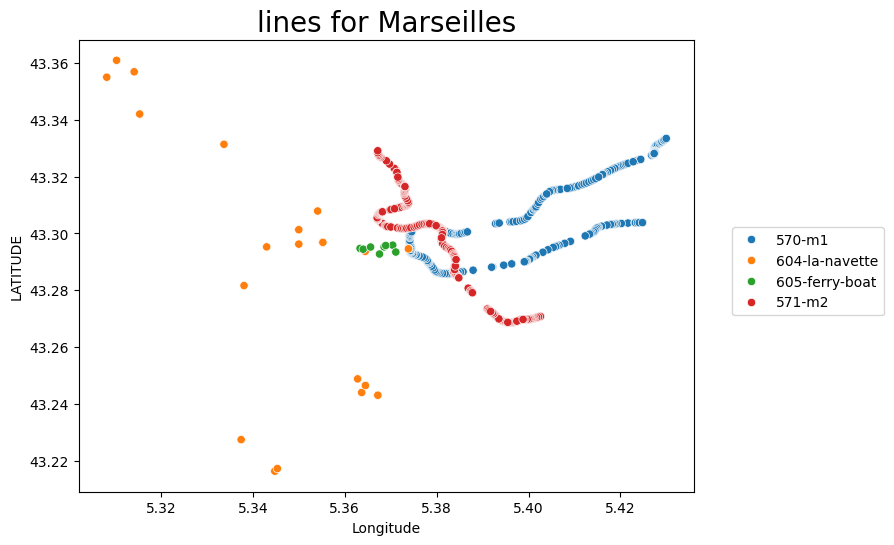

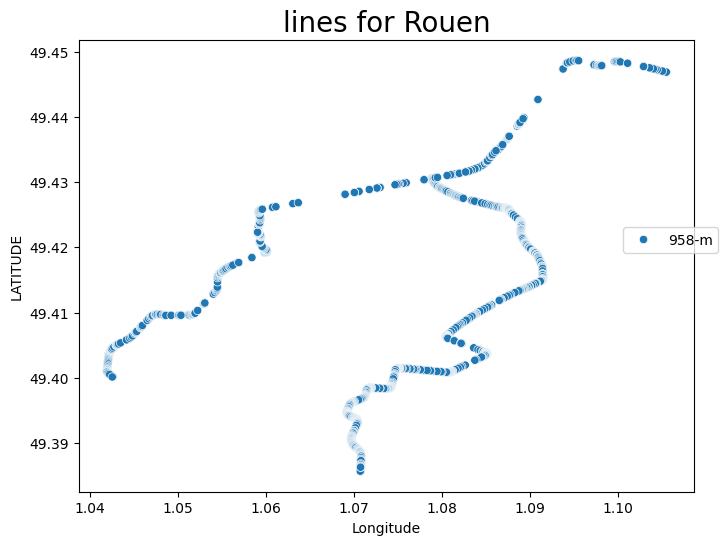

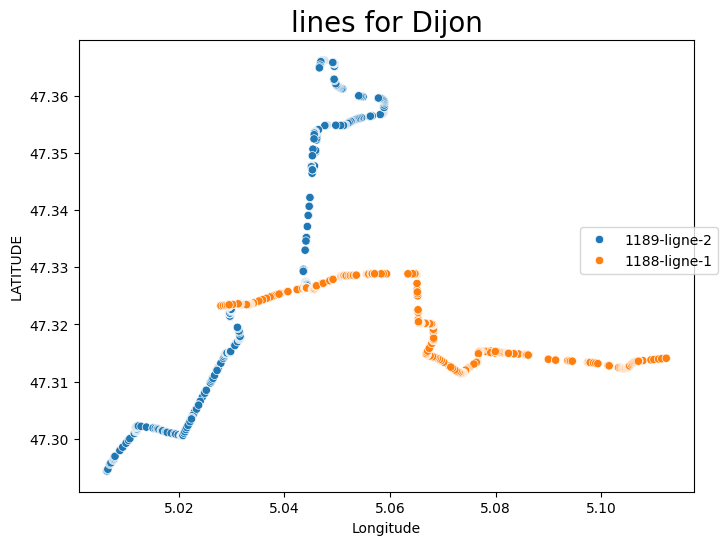

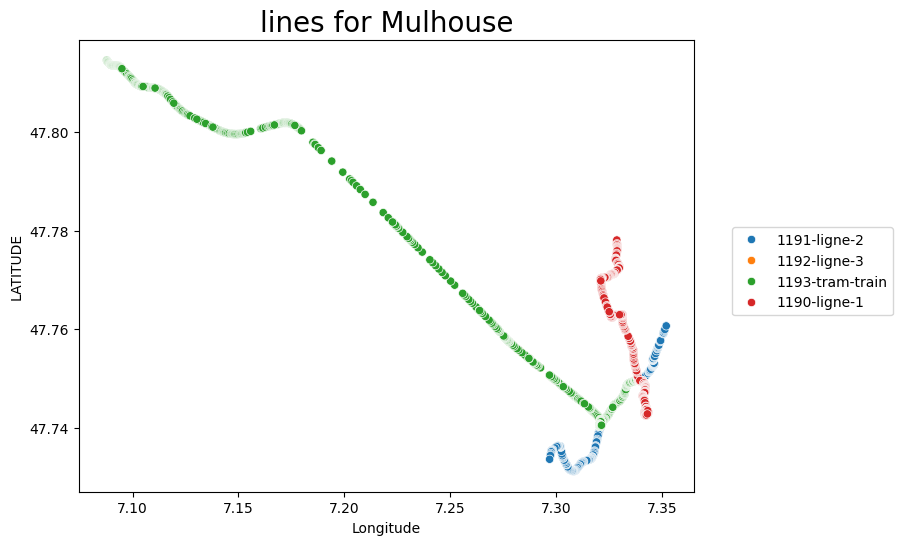

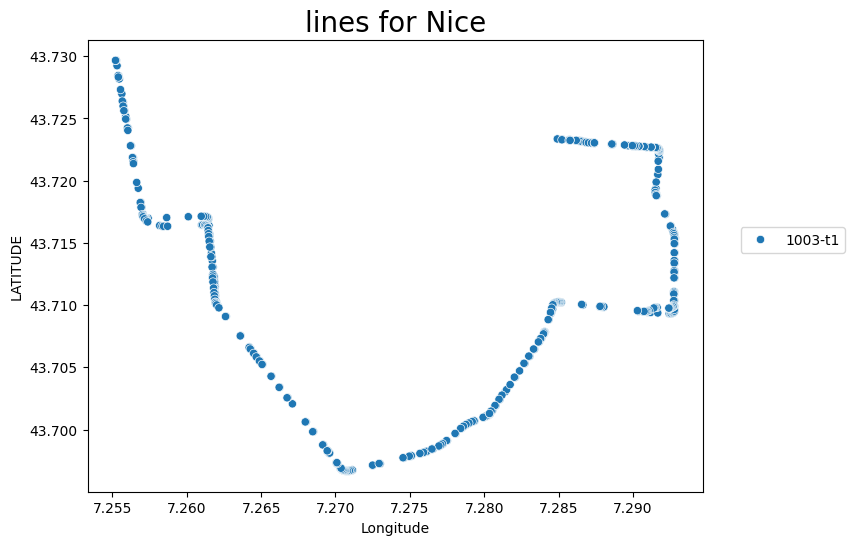

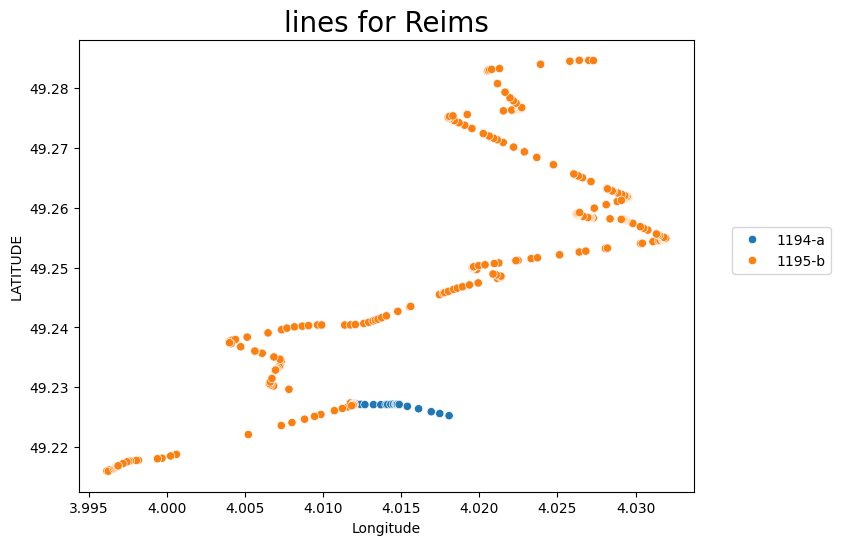

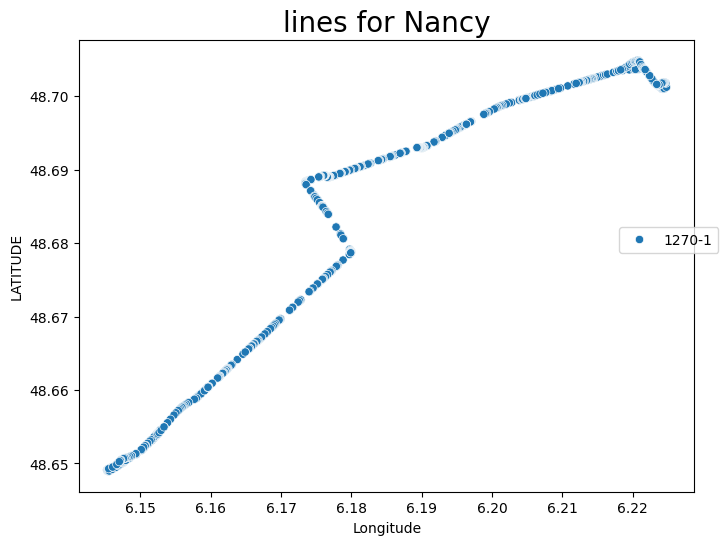

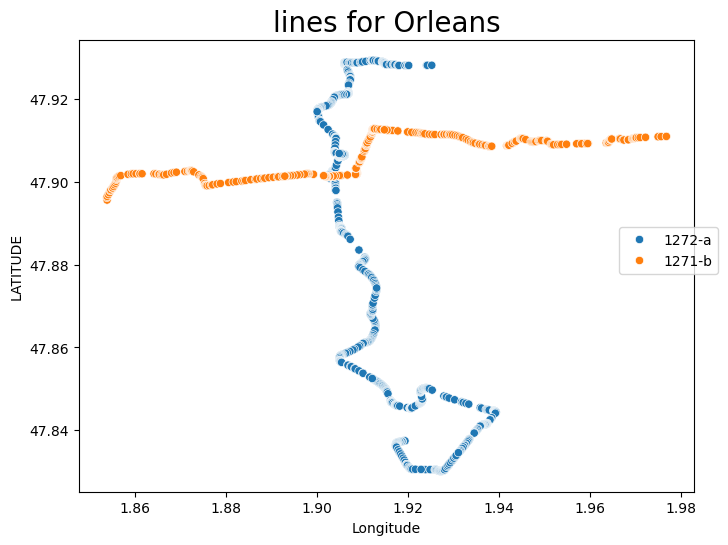

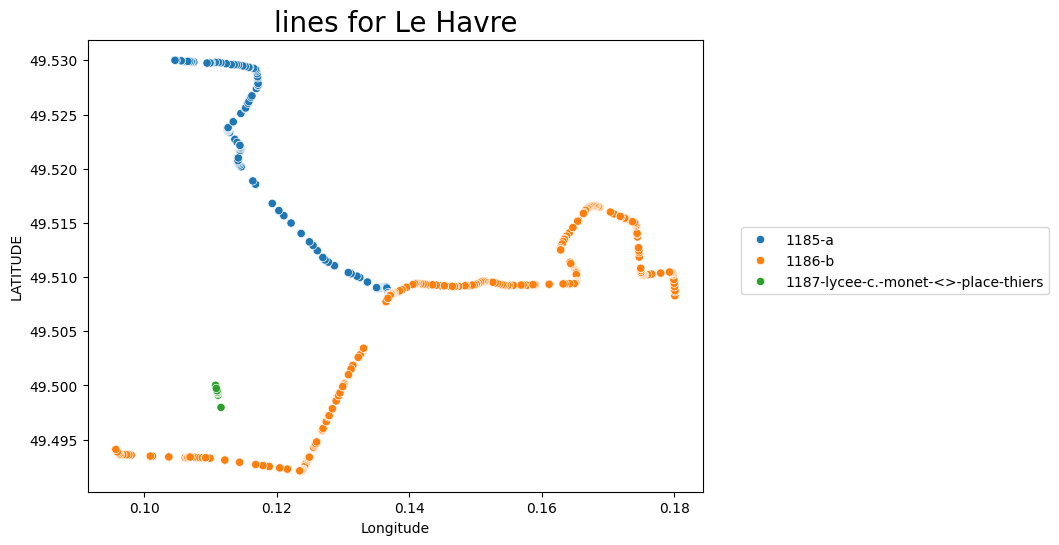

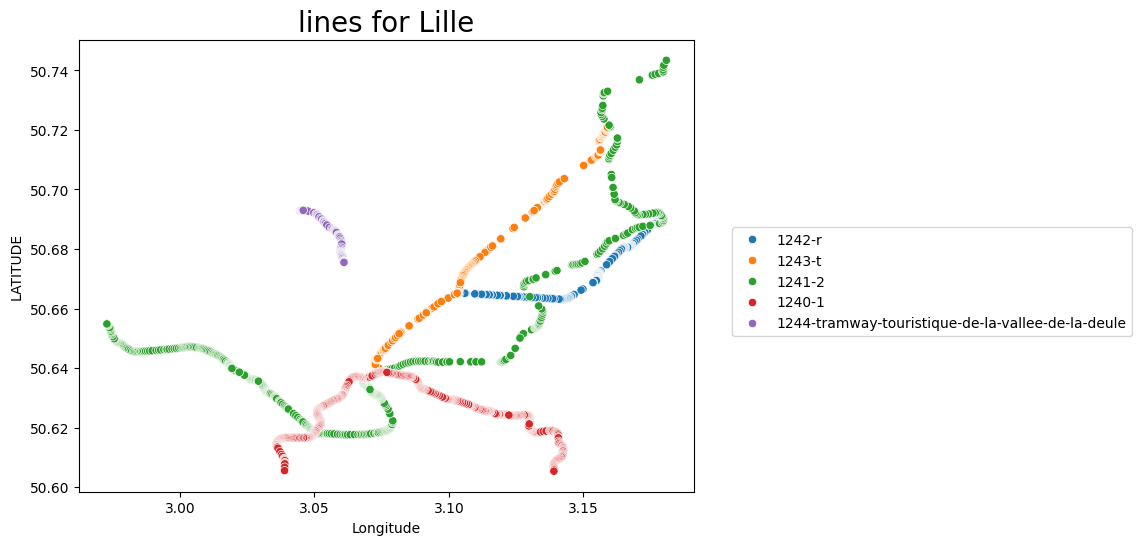

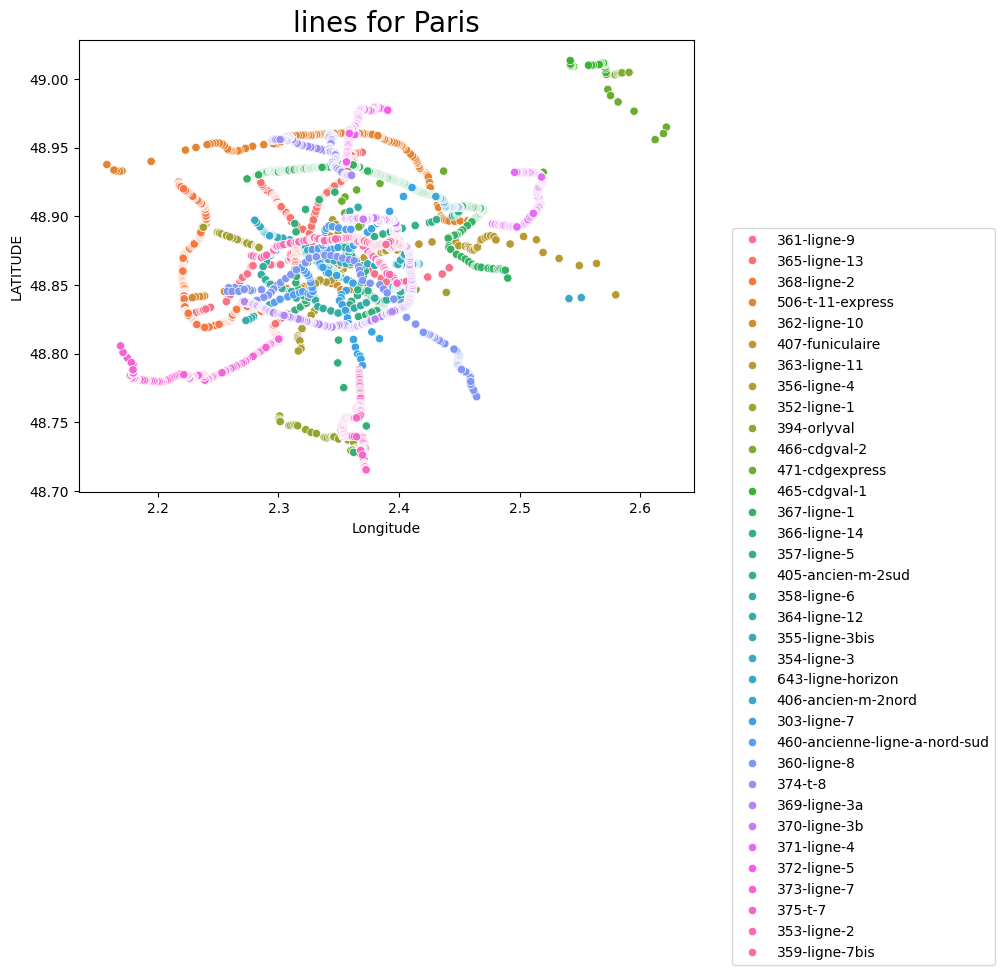

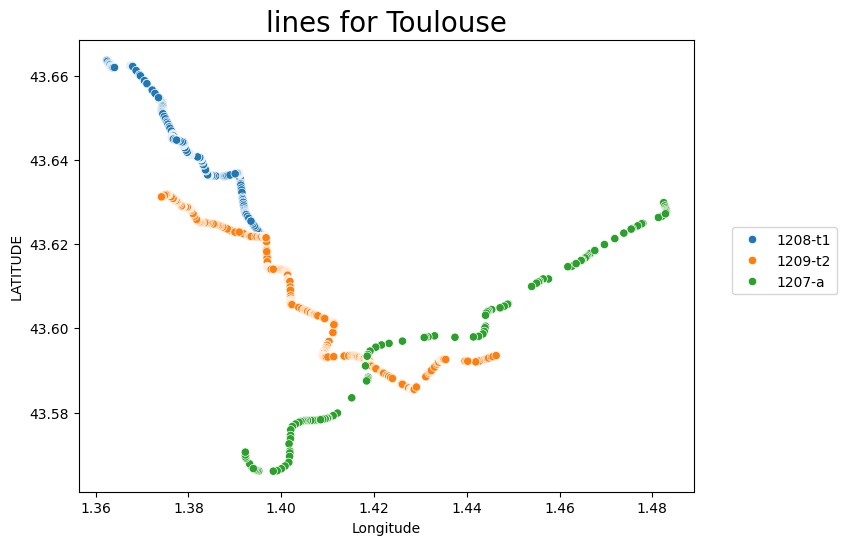

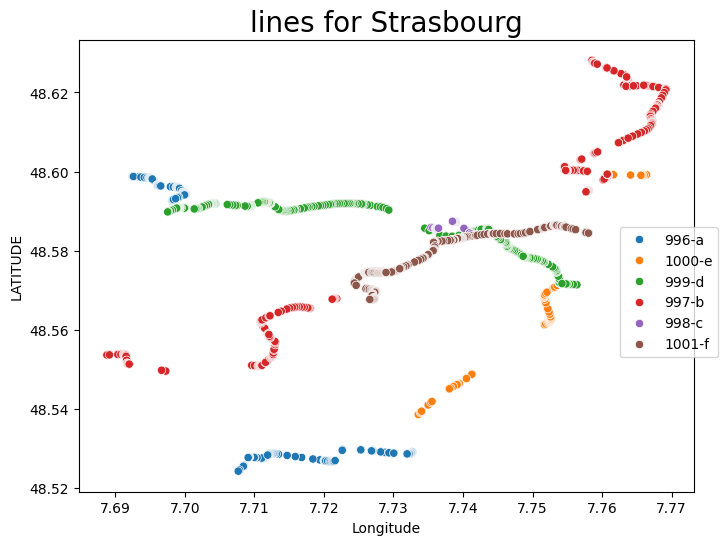

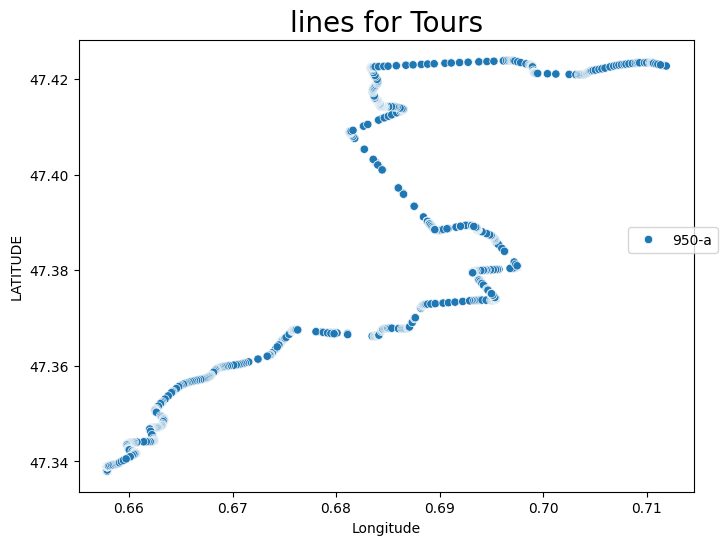

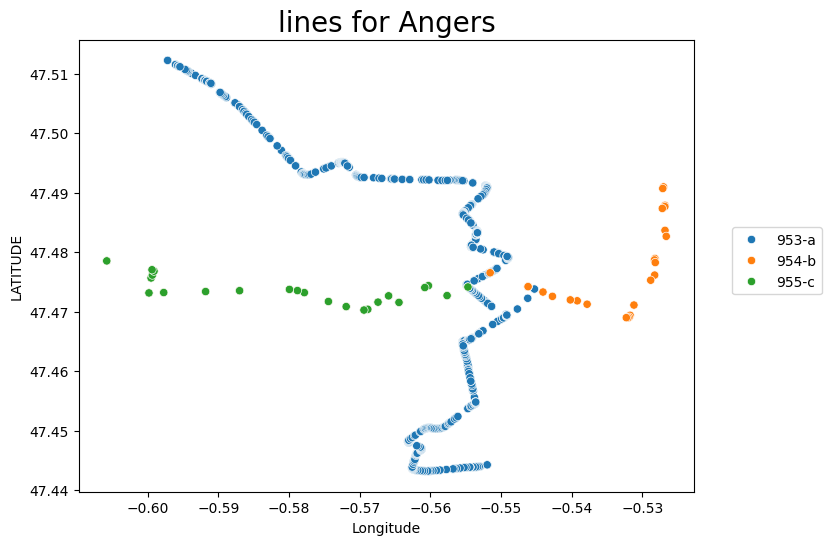

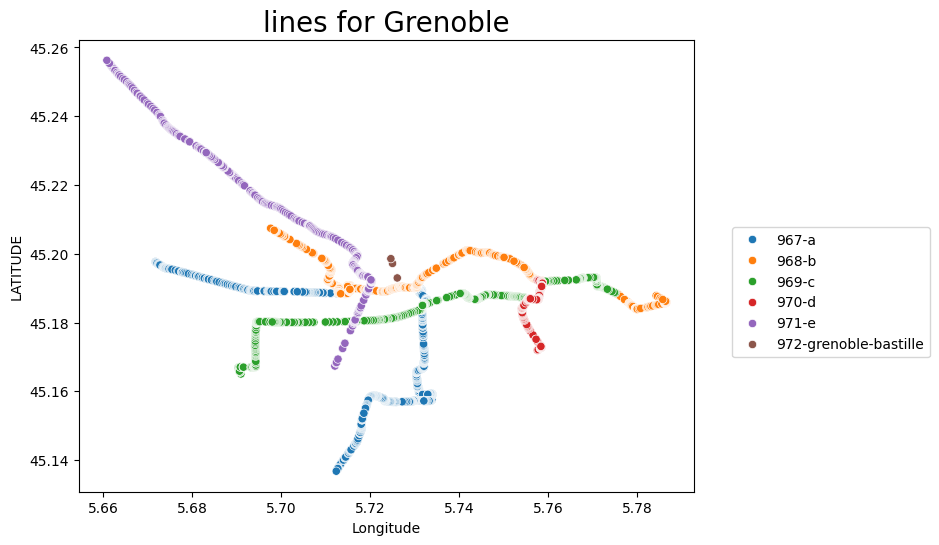

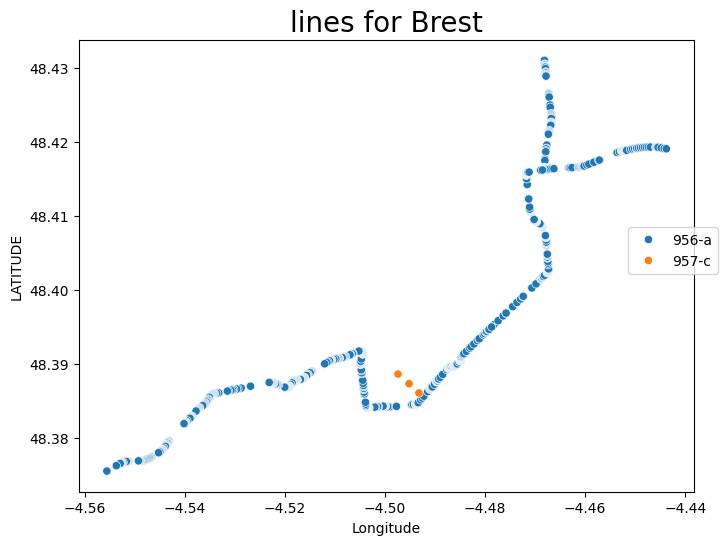

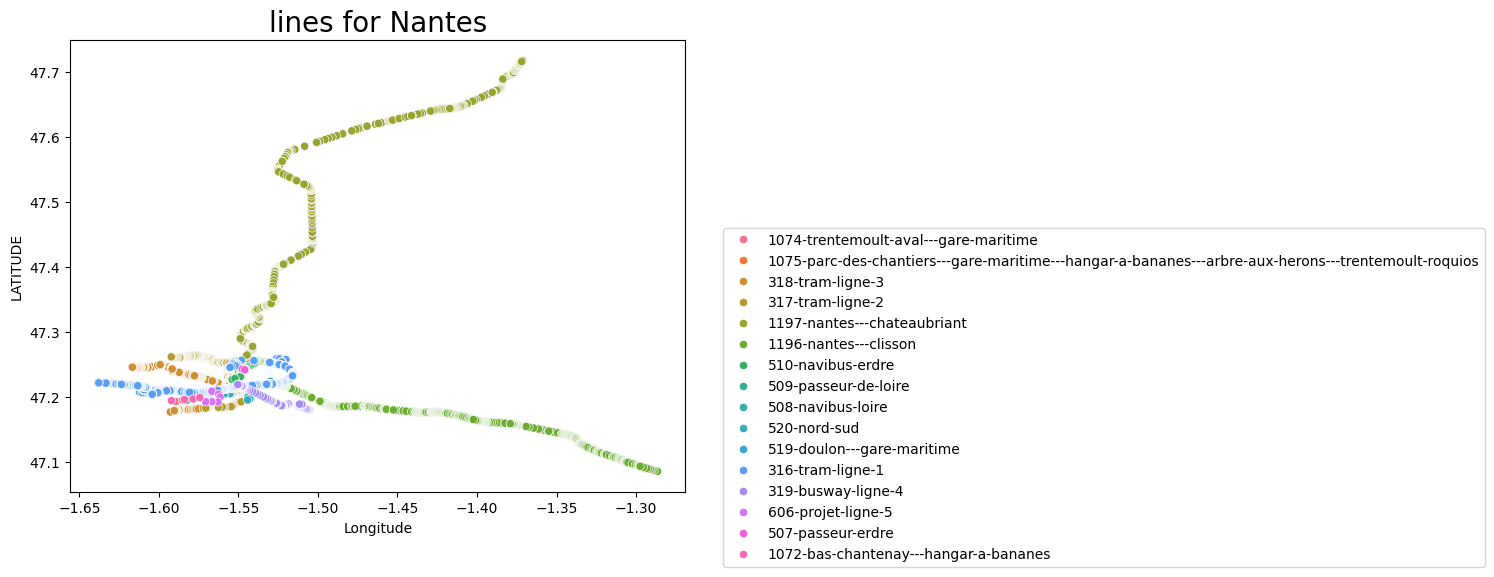

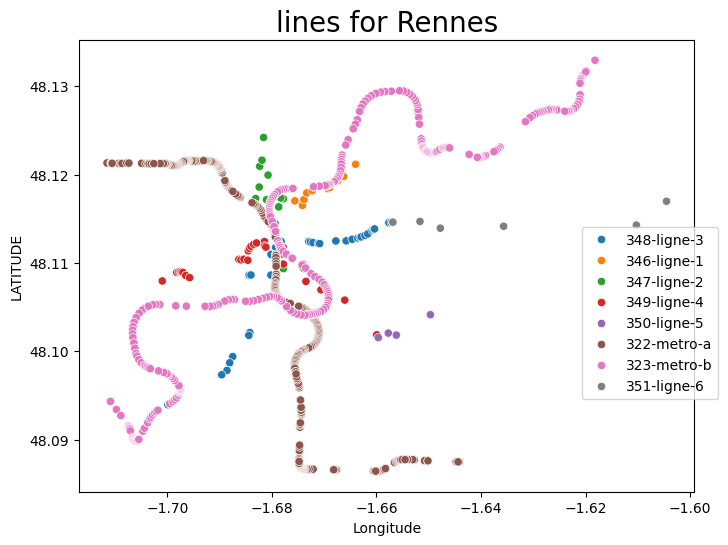

In [110]:
for key, values in data_cities.items():
    if values == {}:
        continue
    longitude = []
    latitude = []
    line = []
    for k, v in values.items():
        for i in range(len(v)):
            longitude.append(v[i][0])
            latitude.append(v[i][1])
            line.append(k)
            fix = pd.DataFrame({'x': longitude,'y': latitude,'z': line})
    fix['x'] = fix['x'].astype(float)
    fix['y'] = fix['y'].astype(float)
    plt.figure(figsize = (27, 27))
    plt.subplot(4, 3, 1) 
    ax = sns.scatterplot(x = "x", y = "y", hue = "z", data = fix)
    plt.legend(loc = 0, bbox_to_anchor=(1.05, 0.6))
    plt.title(f"lines for {key}", size = 20)
    ax.set(xlabel = 'Longitude', ylabel = 'LATITUDE')

In [111]:
import networkx as nx
from math import dist
Graphs = {}
data = {}

def euclidean_distance(station1, station2):
    return dist((float(station1[0]), float(station1[1])), (float(station2[0]), float(station2[1])))

useful_list = name_list

for city in useful_list:
    G1 = nx.Graph()
    working_dict = data_cities[city]

    for line, coordinates in working_dict.items():
        for i in range(len(coordinates) - 1):
            node1 = tuple(map(float, coordinates[i]))
            node2 = tuple(map(float, coordinates[i + 1]))
            G1.add_node(node1)
            G1.add_node(node2)
            G1.add_edge(node1, node2)

    lines = list(working_dict.keys())
    for i in range(len(lines) - 1):
        line1 = lines[i]
        line2 = lines[i + 1]

        closest_distance = float('inf')
        closest_stations = None

        for station1 in working_dict[line1]:
            for station2 in working_dict[line2]:
                distance = euclidean_distance(station1, station2)
                if distance < closest_distance:
                    closest_distance = distance
                    closest_stations = (tuple(map(float, station1)), tuple(map(float, station2)))

        G1.add_edge(closest_stations[0], closest_stations[1])
    if len(G1) > 0:
        Graphs[city] = G1

print(Graphs)

{'Clermont-Ferrand': <networkx.classes.graph.Graph object at 0x16a1c4680>, 'Bordeaux': <networkx.classes.graph.Graph object at 0x2c2b5ecc0>, 'Besancon': <networkx.classes.graph.Graph object at 0x2b932e870>, 'Le Mans': <networkx.classes.graph.Graph object at 0x2c238f800>, 'Montpellier': <networkx.classes.graph.Graph object at 0x147d927e0>, 'Lyons': <networkx.classes.graph.Graph object at 0x2b919d8e0>, 'Marseilles': <networkx.classes.graph.Graph object at 0x2b919f050>, 'Rouen': <networkx.classes.graph.Graph object at 0x2b919eff0>, 'Dijon': <networkx.classes.graph.Graph object at 0x2b919c0b0>, 'Mulhouse': <networkx.classes.graph.Graph object at 0x2b919e7e0>, 'Nice': <networkx.classes.graph.Graph object at 0x2b919d760>, 'Reims': <networkx.classes.graph.Graph object at 0x2b919ef90>, 'Nancy': <networkx.classes.graph.Graph object at 0x2b919e360>, 'Orleans': <networkx.classes.graph.Graph object at 0x2b919e0f0>, 'Le Havre': <networkx.classes.graph.Graph object at 0x2b919e6c0>, 'Lille': <network

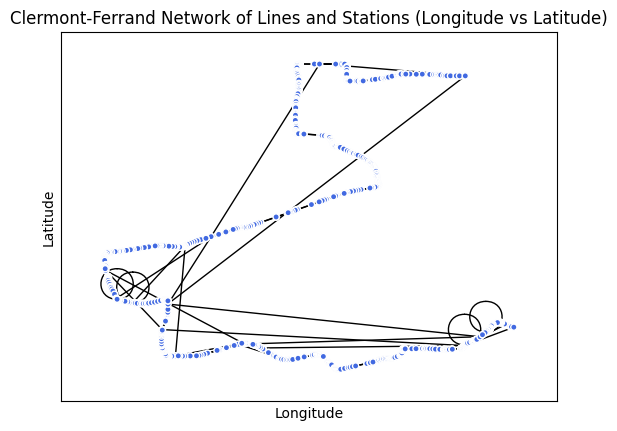

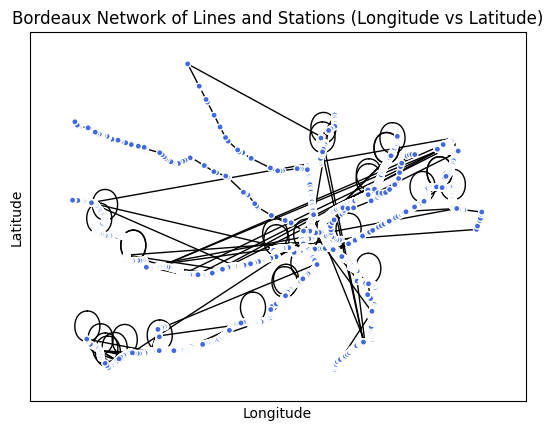

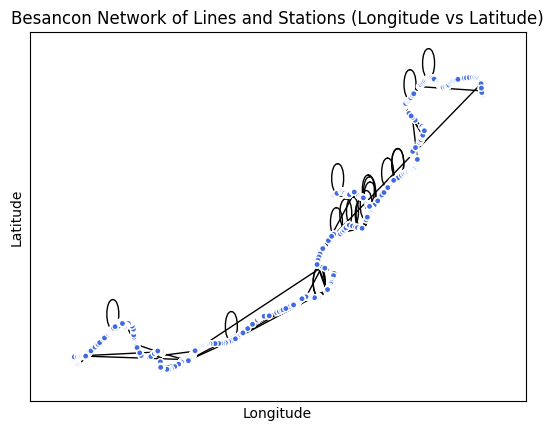

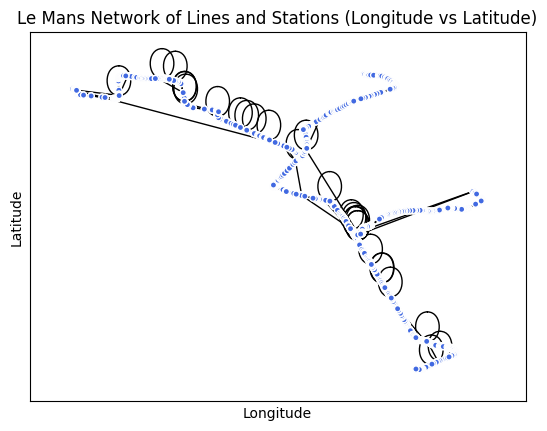

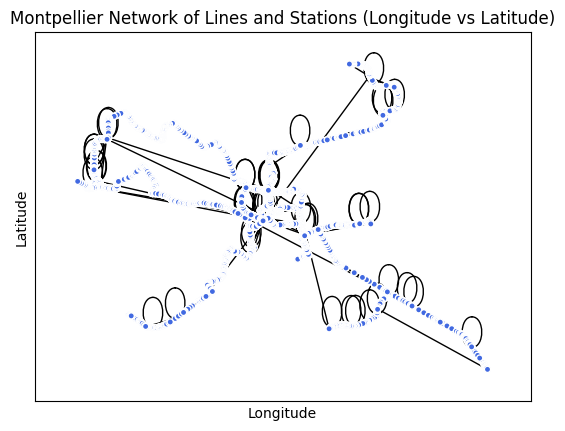

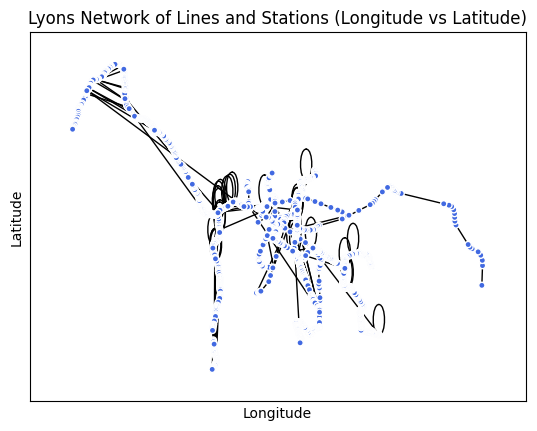

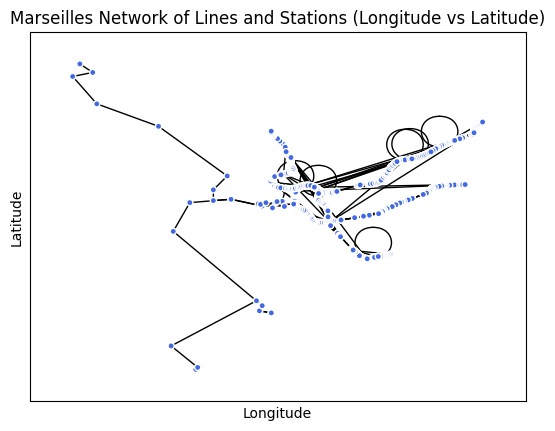

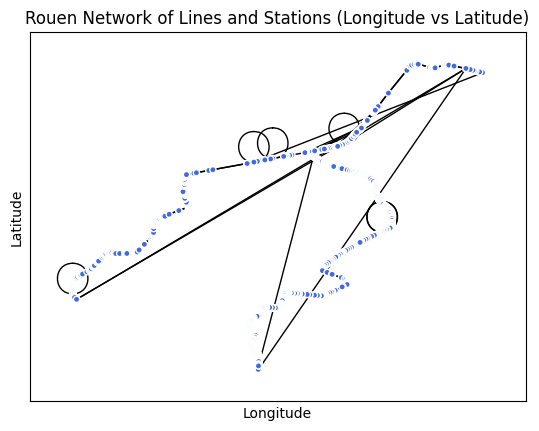

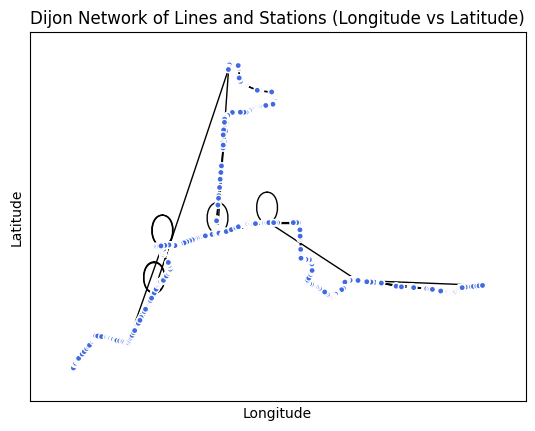

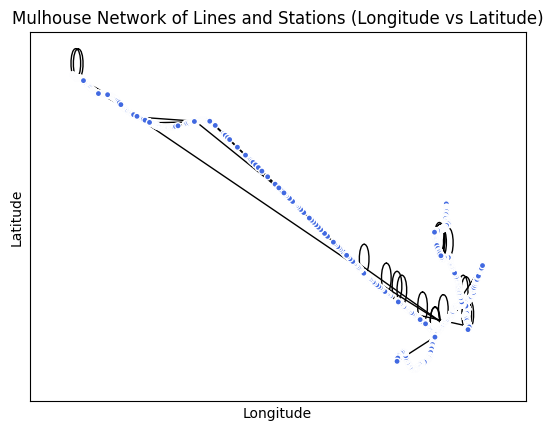

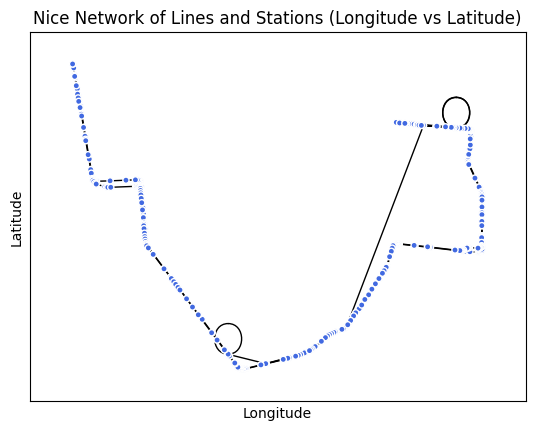

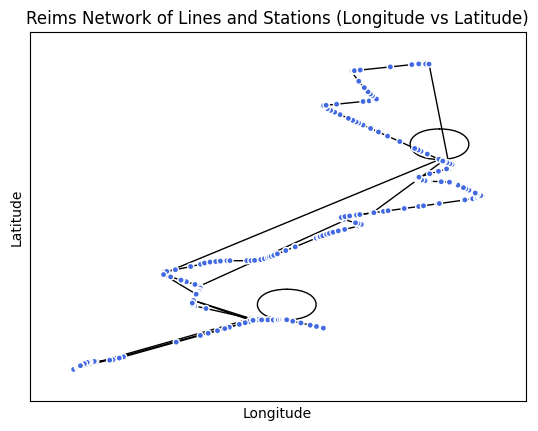

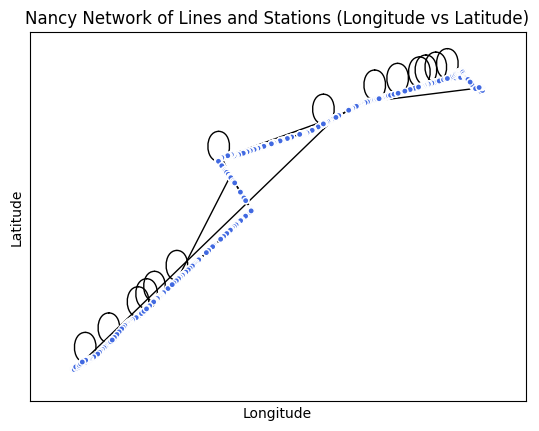

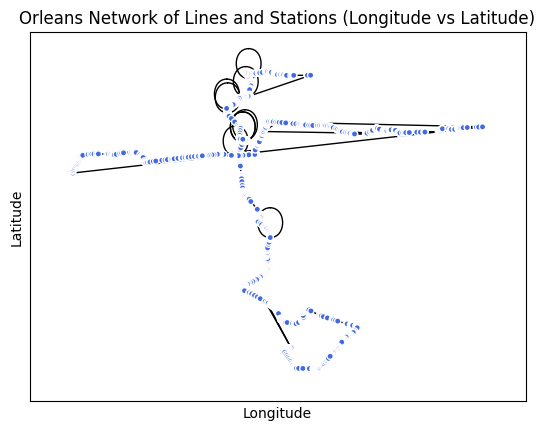

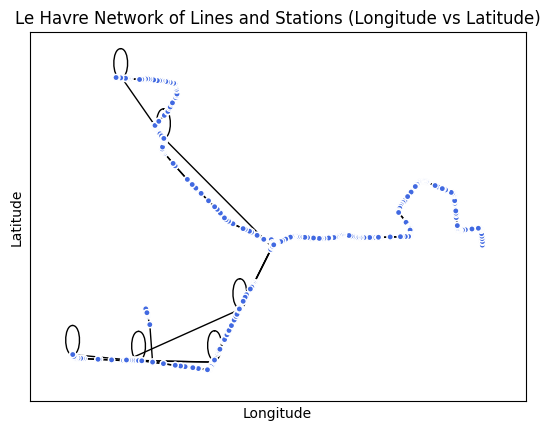

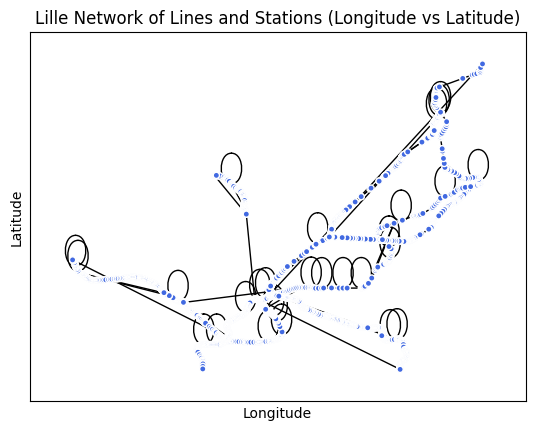

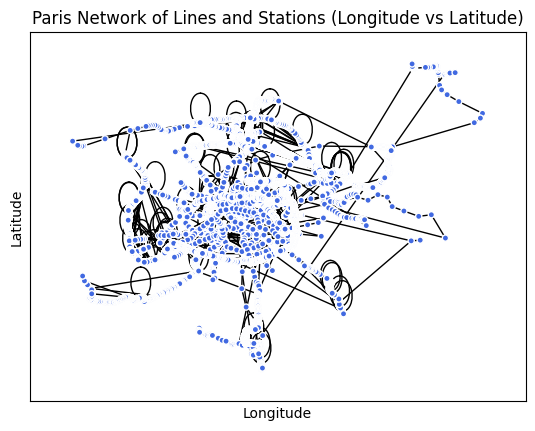

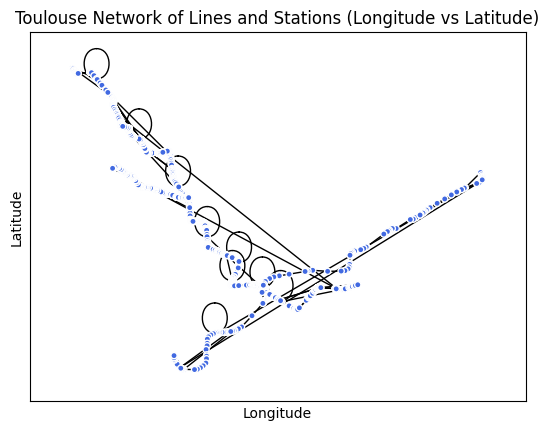

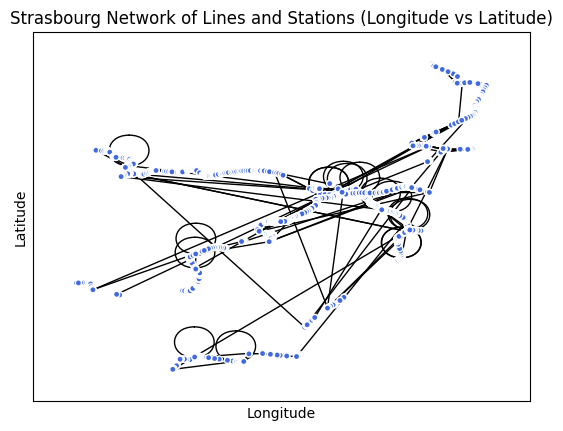

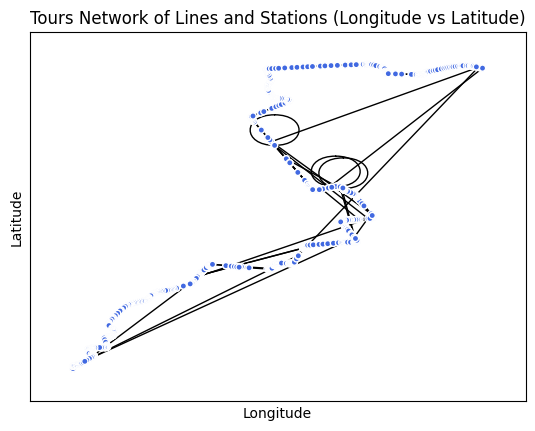

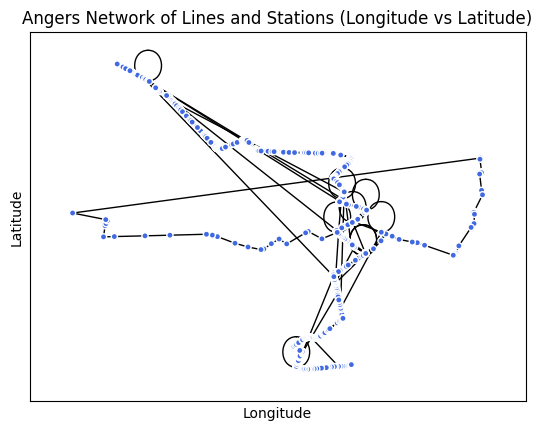

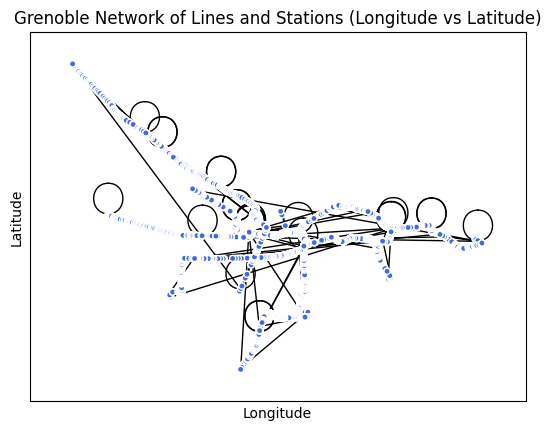

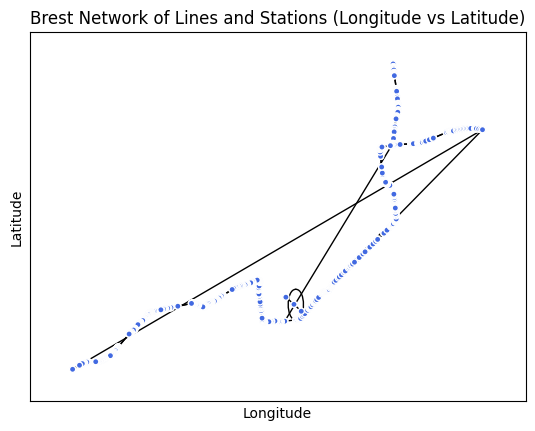

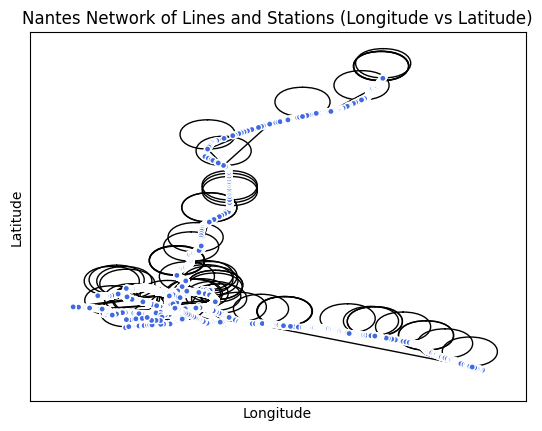

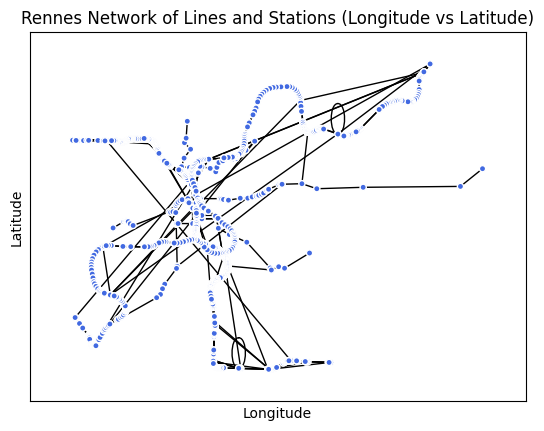

In [112]:
for name, G in Graphs.items():
    pos = {node: (float(node[0]), float(node[1])) for node in G.nodes()}  # Positions based on longitude and latitude

    edge_colors = [G.edges[edge]['line'] if 'line' in G.edges[edge] else 'black' for edge in G.edges]

    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color=edge_colors)

    node_colors = [G.nodes[node]['line'] if 'line' in G.nodes[node] else 'royalblue' for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color=node_colors, linewidths=1, edgecolors='white')  # Set linewidths and edgecolors

    # labels = {node: f"{node}" for node in G.nodes()}
    # nx.draw_networkx_labels(G, pos, labels=labels, font_size=6, font_color='black', font_weight='bold')

    plt.title(f'{name} Network of Lines and Stations (Longitude vs Latitude)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

In [113]:
data = {}
for name, G in Graphs.items():
    if name not in data:
        data[name] = {}
    data[name]["density"] = nx.density(G)

for name, G in Graphs.items():
    data[name]["num_edge"] = len(G.edges())
    data[name]["num_node"] = len(G.nodes())
    data[name]["average_degree"] = sum(dict(G.degree()).values()) / len(G)

for k, v in data.items():
    print(k, v)


Clermont-Ferrand {'density': 0.0016752671704897294, 'num_edge': 1258, 'num_node': 1226, 'average_degree': 2.0522022838499185}
Bordeaux {'density': 0.0004405799007025155, 'num_edge': 4986, 'num_node': 4758, 'average_degree': 2.0958385876418664}
Besancon {'density': 0.0023174644467568507, 'num_edge': 1069, 'num_node': 961, 'average_degree': 2.2247658688865766}
Le Mans {'density': 0.0013298993140166018, 'num_edge': 1783, 'num_node': 1638, 'average_degree': 2.177045177045177}
Montpellier {'density': 0.0005120709821436953, 'num_edge': 4364, 'num_node': 4129, 'average_degree': 2.1138290142891742}
Lyons {'density': 0.0009234558565539303, 'num_edge': 2374, 'num_node': 2268, 'average_degree': 2.0934744268077603}
Marseilles {'density': 0.002529096824789491, 'num_edge': 932, 'num_node': 859, 'average_degree': 2.169965075669383}
Rouen {'density': 0.0012827920049968769, 'num_edge': 1643, 'num_node': 1601, 'average_degree': 2.052467207995003}
Dijon {'density': 0.0018502718041200463, 'num_edge': 1145